# Оптимизация количества тем для LDA

start
dictionary
results
Тем: 2, когерентность: 0.3384
Тем: 3, когерентность: 0.4172
Тем: 4, когерентность: 0.4140
Тем: 5, когерентность: 0.3962
Тем: 6, когерентность: 0.4278
Тем: 7, когерентность: 0.4451
Тем: 8, когерентность: 0.4503
Тем: 9, когерентность: 0.4593
Тем: 10, когерентность: 0.4557
Тем: 11, когерентность: 0.4749
Тем: 12, когерентность: 0.4585


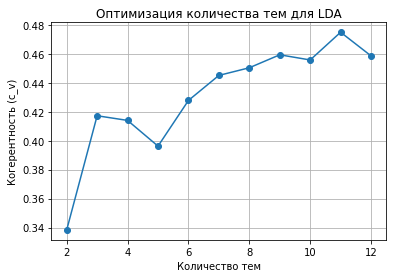

In [6]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import LdaMulticore, CoherenceModel
import matplotlib.pyplot as plt
import os

# Скачиваем:
# nltk.download('punkt')
# nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def load_data(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = f.readlines()
    labels = [1 if line.startswith('__label__2') else 0 for line in data]
    texts = [re.sub(r'__label__\d+\s+', '', line).strip() for line in data]
    return pd.DataFrame({'text': texts, 'label': labels})

def clean_and_tokenize(text):
    text = re.sub(r'[^a-zA-Z ]', '', text.lower())
    tokens = text.split()
    return [t for t in tokens if t not in stop_words and len(t) > 2]

def find_best_num_topics(dictionary, corpus, texts, start=2, limit=12, step=1):
    results = []
    for num_topics in range(start, limit + 1, step):
        lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                           workers=os.cpu_count(), passes=10, random_state=42)
        coherence = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
        print(f"Тем: {num_topics}, когерентность: {coherence:.4f}")
        results.append((num_topics, coherence))
    return results

if __name__ == '__main__':
    print('start')
    df = load_data('content/train.ft.txt')
    negative_reviews = df[df['label'] == 0]['text'].dropna()
    tokenized = [clean_and_tokenize(text) for text in negative_reviews]
    
    print('dictionary')
    dictionary = corpora.Dictionary(tokenized)
    corpus = [dictionary.doc2bow(text) for text in tokenized]

    print('results')
    results = find_best_num_topics(dictionary, corpus, tokenized, start=2, limit=12)

    # Построить график когерентности
    x, y = zip(*results)
    plt.plot(x, y, marker='o')
    plt.xlabel('Количество тем')
    plt.ylabel('Когерентность (c_v)')
    plt.title('Оптимизация количества тем для LDA')
    plt.grid(True)
    plt.savefig('coherence_plot.png')
    plt.show()


## Вывод:
Оптимальное количество тем — 11, т.к. при этом значение когерентности максимально.

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import os

stop_words = set(stopwords.words('english'))

def load_data(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = f.readlines()
    labels = [1 if line.startswith('__label__2') else 0 for line in data]
    texts = [re.sub(r'__label__\d+\s+', '', line).strip() for line in data]
    return pd.DataFrame({'text': texts, 'label': labels})

def clean_and_tokenize(text):
    text = re.sub(r'[^a-zA-Z ]', '', text.lower())
    tokens = text.split()  # Быстрее, чем nltk.tokenize
    return [t for t in tokens if t not in stop_words and len(t) > 2]

if __name__ == '__main__':
    print('start')
    df = load_data('content/train.ft.txt')
    print('negative_reviews')
    negative_reviews = df[df['label'] == 0]['text'].dropna()
    tokenized = [clean_and_tokenize(text) for text in negative_reviews]
    
    print('dictionary')
    dictionary = corpora.Dictionary(tokenized)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokenized]
    
    print('lda_model')
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=11,
        passes=10,
        workers=os.cpu_count(),
        random_state=42
    )

    for i, topic in lda_model.print_topics(num_words=10):
        print(f"Тема {i+1}: {topic}")

    vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
    pyLDAvis.save_html(vis_data, 'lda_vis11.html')
    print("Готово! Файл сохранён как lda_vis11.html")

start
negative_reviews
dictionary
lda_model
Тема 1: 0.015*"album" + 0.014*"like" + 0.013*"music" + 0.011*"songs" + 0.010*"one" + 0.009*"good" + 0.008*"dont" + 0.007*"song" + 0.005*"really" + 0.005*"get"
Тема 2: 0.009*"product" + 0.009*"like" + 0.008*"would" + 0.008*"one" + 0.008*"use" + 0.007*"get" + 0.006*"good" + 0.006*"dont" + 0.005*"used" + 0.005*"water"
Тема 3: 0.014*"one" + 0.010*"work" + 0.008*"product" + 0.008*"would" + 0.007*"use" + 0.007*"bought" + 0.007*"buy" + 0.007*"get" + 0.007*"time" + 0.006*"months"
Тема 4: 0.036*"book" + 0.020*"game" + 0.007*"good" + 0.007*"dont" + 0.007*"would" + 0.007*"get" + 0.006*"information" + 0.006*"money" + 0.006*"buy" + 0.006*"one"
Тема 5: 0.009*"one" + 0.008*"would" + 0.007*"fit" + 0.007*"get" + 0.006*"dont" + 0.006*"use" + 0.006*"work" + 0.006*"product" + 0.005*"back" + 0.005*"like"
Тема 6: 0.036*"movie" + 0.012*"film" + 0.011*"one" + 0.011*"like" + 0.009*"bad" + 0.008*"good" + 0.007*"dont" + 0.006*"time" + 0.006*"even" + 0.006*"really"
Тема

## Результат - lda_vis11.html

![Коэффициент когерентности](img/Screenshot_1.jpg)

In [15]:
from IPython.display import IFrame

IFrame(src='lda_vis11.html', width='100%', height='880px')

# Выводы

## Тема 1
### Топ-слова:
book, read, books, story, reading, characters, author, plot, writing, novel, pages, better


### Акценты покупателей:

- Скучный или плохо написанный сюжет (boring, plot, writing)

- Слабых персонажей (characters, author)

- Завышенные ожидания — книга не оправдала ожиданий (would, could, didnt, better)

- Общее разочарование в чтении или покупке книги


### Практические выводы:
- Возможно, стоит перепроверить описания книг — они могут вводить в заблуждение.

- Если это отзывы о конкретных жанрах — сегментировать и рекомендовать другим читателям более популярные альтернативы.

- Может быть полезно отметить книги, которые получают такую тему чаще всего — как кандидаты на улучшение, редактирование или удаление.

## Тема 2
### Топ-слова:
one, work, product, would, use, bought, buy, get, time, months, unit, worked, battery, back, dont, problem, phone, quality, used, year

###  Акценты покупателей:
- Проблемы с функционированием (work, worked, working, doesn’t work, problem, battery, unit, used, quality)

- Жалобы на недолговечность (months, year, back, first, time)

- Недовольство покупкой в целом (bought, buy, product, would, dont, one)

- Частые упоминания телефонов/электроники (phone, battery)


### Практические выводы:
- Возможно, стоит отметить товары или категории, в которых эта тема преобладает.

- Рекомендуется внедрить мониторинг на основе этих ключевых слов для будущих отзывов.

## Тема 3
### Топ-слова:
movie, film, watch, movies, story, acting, boring, worst, waste, plot, see, time, money

###  Акценты покупателей:
- Разочарование в сюжете и актёрской игре (story, acting, boring, plot, ever, worst, bad, made)

- Потеря времени и денег (waste, time, money, even, could, would, much, get)

- Ожидания не оправдались (like, better, dont, really, one)

- Объекты обсуждения — кино и просмотр (movie, film, watch, movies, watching, seen, see)

###  Практические выводы:
- Анализ отзывов об аудиовизуальном контенте поможет выявить фильмы или видеопродукты, вызывающие наибольшее разочарование.

- Тематику можно использовать для автоматической маркировки негативных отзывов о фильмах — особенно тех, где упоминаются пустые траты времени и слабый сюжет.

- Подобные жалобы часто сопровождаются снижением лояльности: важно учитывать их при разработке рекомендаций, подборе партнёрского контента и формировании витрин.

## Тема 4
### Топ-слова:
album, like, music, songs, one, good, dont, song, really, get, buy, great, band, even, would, better, sound, bad, much, first, listen, new, best, fan, think, dvd, love, time, original, want

###  Акценты покупателей:
- Разочарование в музыкальных альбомах (album, songs, band, song, music, sound, dvd)

- Низкое качество или несоответствие ожиданиям (bad, dont, would, want, better, even, really, think)

- Недовольство покупкой (buy, get, much, money, first)

- Эмоциональные оценки — любовь фанатов не оправдалась (love, like, fan, best, great, original)

###  Практические выводы:
- Эта тема отражает негативную реакцию на музыкальные товары — возможно, цифровые альбомы, CD/DVD, мерч групп. Важно учитывать ожидания фанатской аудитории, так как она более требовательна.

- Можно использовать тему для анализа отзывов на музыкальные релизы, выявления альбомов с провалами.

- Полезна для оценки качества рекомендательных систем: пользователи, разочаровавшиеся в релеванте, могут терять доверие к платформе.

## Тема 5
### Топ-слова:
product, like, would, one, use, get, good, dont, used, water, time, work, even, much, bought, really, money, hair, buy, didnt, well, doesnt, using, better, tried, also, first, great, made, make

###  Акценты покупателей:
- Устройства не работают так, как ожидалось (use, work, used, using, doesnt, didnt, make, better)

- Недовольство реальным опытом использования (water, hair, money, bought, time, tried, really, well)

- Несоответствие ожиданиям и сомнения в целесообразности покупки (like, would, even, great, also, one, get) 

###  Практические выводы:
- Эта тема отражает разочарование в повседневной работе умного устройства: часто функциональность заявлена, но не реализована на практике.

- Необходимо:

    - Проверить описание и инструкции к устройствам — часто ли обещания в маркетинге не соответствуют реальности.

    - Идентифицировать группы товаров (особенно умные приборы гигиены или взаимодействующие с водой), где эта тема превалирует.

- Возможно, стоит внедрить улучшенные сценарии onboarding-а, чтобы пользователи лучше понимали, как правильно использовать устройство и чего от него ожидать.

## Тема 6
### Топ-слова:
book, would, one, read, people, like, dont, author, history, want, good, many, know, world, written, much, time, even, think, money, work, new, make, way, children, american, nothing, say, god, well

###  Акценты покупателей:
- Негативный опыт при взаимодействии с "умными" устройствами, связанными с чтением или информацией (book, read, author, history, written, world, children, american)

- Разочарование в рекомендованном/озвученном контенте (would, dont, want, say, god, nothing, know, like)

- Недоверие к “интеллектуальности” устройства (think, even, make, way, new, know)


###  Практические выводы:
- Вероятно, отзывы касаются умных голосовых помощников, колонок с озвучкой книг, читалок или устройств с авто-рекомендациями контента.

- Тема указывает на:

    - Проблемы с качеством и актуальностью рекомендованного контента (god, history, children, american, say)

- Рекомендуется:

    - Пересмотреть алгоритмы рекомендаций и контент по умолчанию.

    - Настроить фильтры или дать пользователю возможность настроить интересующие тематики.

    - Возможно, стоит снизить "навязчивость" устройства в тех случаях, когда оно озвучивает что-либо без запроса.

## Тема 7
### Топ-слова:
book, game, good, dont, would, get, information, money, buy, one, much, like, better, many, even, use, time, games, find, version, really, want, new, waste, play, books, know, found, edition, text

###  Акценты покупателей:
- Разочарование в мультимедийных возможностях устройства (book, books, text, game, games, play, version, edition)

- Недовольство качеством и полезностью информации (information, find, know, text, waste, better, much) 

- Экономическая неудовлетворённость (buy, money, get, would, want, new, dont) 


###  Практические выводы:
- Эта тема может сигнализировать о низкой эффективности контента, поставляемого вместе с устройством:

    - Играми, книгами, обучающими программами.

- Возможные причины:

    - Недостаточное количество доступного контента.

    - Плохой перевод/озвучка.

    - Нерелевантные версии (version, edition).

- Рекомендуется:
 
    - Увеличить выбор локализованного и качественного контента для устройств.
 
    - Пересмотреть позиционирование устройства: если оно заявляется как "мультимедийный центр", то пользователи ждут контента из коробки.

    - Ввести предпросмотр или демо: чтобы пользователь мог понять, что именно он получит перед покупкой/активацией.

## Тема 8
### Топ-слова:
product, amazon, dvd, received, item, would, ordered, one, never, order, get, buy, return, back, company, sent, service, seller, customer, shipping, time, dont, purchase, got, still, refund, wrong, purchased, season, even

###  Акценты покупателей:
- Проблемы с доставкой и логистикой (ordered, received, shipping, order, sent, purchased, time, never, got)

- Возвраты и недовольство покупкой (return, refund, back, wrong, still, dont, company, seller, amazon)

- Низкое качество клиентского сервиса (customer, service, seller, company)

###  Практические выводы:
- Эта тема отражает вопросы не к самому “умному” устройству, а к процессу покупки, доставки и взаимодействия с продавцом.

- Рекомендуется:

    - Усилить контроль качества логистики: сроки доставки, комплектность, упаковка.

    - Обеспечить более прозрачную и отзывчивую поддержку по вопросам возвратов.

    - При работе с маркетплейсами (например, amazon) — контролировать продавцов и отзывы, особенно по сезону (season — возможный пик покупок, например, на праздники).

- Эта тема — важный индикатор непрямого негативного опыта, который влияет на общее восприятие устройства, даже если само оно исправно.

## Тема 9
### Топ-слова:
one, would, fit, get, dont, use, work, product, back, like, time, good, bought, buy, well, doesnt, even, great, much, money, drive, better, put, could, seat, hard, first, way, size, made

###  Акценты покупателей:
- Проблемы с совместимостью и установкой (fit, seat, size, back, hard, put, way) 

- Недовольство качеством сборки и работоспособностью (doesnt, work, made, product, use, get, bought, buy, drive) 

- Общее ощущение «не стоит своих денег» (money, good, well, even, much, great)

###  Практические выводы:
- Эта тема явно указывает на физические/механические проблемы умных устройств:

    - Неподходящие крепления, габариты, несовместимость с мебелью или автомобилем (seat, fit, drive).

- Возможные рекомендации:

    - Обновить технические спецификации и описание товара, включая:

        - точные размеры;

        - совместимость;

        - инструкции по установке.

    - Добавить видеоинструкции и примеры применения, чтобы избежать ошибочных покупок.

    - Усилить контроль качества сборки и проверку на совместимость с распространёнными платформами (крепления, розетки, держатели и т.д.).



## Тема 10
### Топ-слова:
money, would, quality, like, one, dont, toy, old, waste, bought, buy, get, disappointed, even, got, son, cheap, really, christmas, year, made, daughter, much, price, time, worth, set, picture, little, good

###  Акценты покупателей:
- Ощущение низкой ценности и разочарование в покупке (money, waste, disappointed, worth, cheap, price, quality)

- Ассоциации с детскими игрушками (toy, son, daughter, christmas, picture, set, little)

- Недовольство качеством сборки и функционалом (made, old, dont, buy, cheap, get)

###  Практические выводы:
- Следует пересмотреть позиционирование продукта:

    - Если продукт позиционируется как "умное устройство", он не должен восприниматься как игрушка или бесполезный подарок.

    - Особенно важно быть осторожными в период сезонных продаж (например, Рождества) — эти устройства часто выбирают на подарок, и негативные впечатления могут сильно повлиять на репутацию бренда.

- Рекомендуется улучшить:

    - материалы, упаковку, и внешний вид, чтобы не возникало ощущение "дешёвки";

    - честность в описании — не завышать ожидания в рекламных материалах;

    - добавить примеры использования, чтобы показать реальную ценность и назначение устройства.

## Тема 11
### Топ-слова:
sound, quality, good, like, noise, hear, volume, radio, would, loud, headphones, get, one, ear, dont, much, better, great, audio, ipod, even, really, use, music, speakers, poor, sounds, bought, static, also

###  Акценты покупателей:
- Недовольство качеством звука (sound, noise, static, poor, volume, loud, radio, speakers, audio)

- Критика гарнитур и наушников (headphones, ear, hear, ipod, music) 

- Низкая ожидаемая ценность (dont, get, use, would, bought)

###  Практические выводы:
- Проверить и улучшить аудиокомпоненты устройств:

    - улучшить громкость, чистоту звучания, устранить шумы/статику, особенно при использовании радио и беспроводных соединений;

    - проверить работу с гарнитурами — жалобы на одно ухо указывают на возможные проблемы с разъёмами или Bluetooth-соединением.

- Добавить технические детали в описание товара:

    - чтобы снизить завышенные ожидания покупателей, важно заранее обозначать ограничения по качеству звука, совместимости и типу звуковых кодеков.

- Рассмотреть выпуск улучшенной аудиоверсии устройства:

    - если аудио — ключевая проблема в части отзывов, обновлённая линейка с усиленным звуком может повысить удовлетворённость пользователей.